# About activity_descriptors_detector.ipynb

This notebook detects different aspects of activities from log files.

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
from tabulate import tabulate
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8,4

# Preparing activity descriptive data

## Getting log data

In [3]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file sperez8_beers_log_files_per_student.txt has been unpickled and loaded
The file sperez8_capacitor_log_files_per_student.txt has been unpickled and loaded


In [4]:
students = log_files_per_sim['beers'].keys()

## Two types of detectors

In [5]:
def detect_action(log_files_per_sim,students,initial_value,update_function,get_use_function,ignore_model_events=True):
    '''
    This function is a generic detector for a specific action.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        initial_value (): False for binary usage, 0 for number of times students did something, etc...
        update_function (function): takes use from 1st log file and compares it to the next using max, sum, min, etc...
        get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        action_use (dict): a dictionary by sim by student of use of action
    '''
    action_use = {'beers':{sid:initial_value for sid in students},'capacitor':{sid:initial_value for sid in students}}
    
    for sim in ['beers','capacitor']:
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            use = initial_value

            for log in logs:
                df = prep_parsing_data(log,remove_model_events=ignore_model_events)
                if not df.empty:
                    use = update_function([use, get_use_function(df)])
            
            action_use[sim][sid] = use
    
    return action_use

In [6]:
def detect_multiple_actions(log_files_per_sim,students,detectors):
    '''
    This function is a generic actions detector.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        detectors (list of tuples): Contains each detector:
            action (string): name of the action to use as column name in dataframe
            update_function (function): takes use from 1st log file and compares it to the next using max, sum, min, etc...
            get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        df (DataFrame): a dataframe with sim*student rows and one column per action detected
    '''
    df_action_l = pd.DataFrame({'sid':students,'sim':'L'})
    df_action_c = pd.DataFrame({'sid':students,'sim':'C'})
    
    for sim,df_action in [('beers',df_action_l),('capacitor',df_action_c)]:
        action_use = {action:{sid:0 for sid in students} for action,_,_ in detectors}
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            for log in logs:
                df = prep_parsing_data(log,remove_model_events=False)
                if not df.empty:
                    for action,update_function,get_use_function in detectors:
                        action_use[action][sid] = update_function([action_use[action][sid], get_use_function(df)])
    
        for action,_,_ in detectors:
            df_action[action] = df_action['sid'].map(action_use[action])
    return pd.concat([df_action_l,df_action_c])

## Actions to detect

### Activity duration and user actions

In [7]:
def get_activity_duration(df):
    return list(df.sort_values(by='Time')['Time'])[-1]

In [8]:
def get_number_actions(df):
    #ignore model events count dragging as 1 event (by only counting dragStarted)
    return df[(df['User or Model']!='model')&(df['Event']!='dragged')&(df['Event']!='dragEnded')].shape[0]

### Exploration measures

In [9]:
def get_time_second_record(df):
    times = list(df[df['Event']=='recording data']['Time'])
    if len(times)>=2:
        times.sort()
        return times[1] #return the time of the second record
    else:
        return list(df.sort_values(by='Time')['Time'])[-1] #else, return last time stamp

### Uses of different components

In [10]:
def get_use_concentration_plus_minus(df):
    if 'solutionControls slider' in df['Item'].tolist():
        return 1
    else:
        return 0

In [11]:
# #FIX ME
# def get_number_words_notes(df):
# #     print df.head()
#     return max([len(str(text).split(' ')) if str(text)=='nan' else 0 for text in df['Notes'].tolist()])

In [12]:
def get_use_move_trial(df):
    if 'Moving trial in table' in df['Event'].tolist():
        return 1
    else:
        return 0

In [13]:
def get_use_remove_trial(df):
    if 'Removing data from table' in df['Event'].tolist():
        return 1
    else:
        return 0

In [14]:
def get_use_restore(df):
    if 'Restoring sim state from trial' in df['Event'].tolist():
        return 1
    else:
        return 0

## Running detectors

In [15]:
detectors = [('duration',sum,get_activity_duration),
             ('number of actions',sum,get_number_actions),
             ('time second record',sum,get_time_second_record),
             ('use concentration buttons',max,get_use_concentration_plus_minus),
             ('use restore',max,get_use_restore),
             ('use remove trial',max,get_use_remove_trial),
             ('use move trial',max,get_use_move_trial),
#              ('number of words in notes',max,get_number_words_notes),
            ]

In [16]:
# #test 1 student
detect_multiple_actions(log_files_per_sim,[10866146],detectors)

,sid,sim,duration,number of actions,time second record,use concentration buttons,use restore,use remove trial,use move trial
0,10866146,L,1045.064,263,796.405,1,1,1,0
0,10866146,C,851.686,50,851.686,0,0,0,0


In [17]:
df = detect_multiple_actions(log_files_per_sim,students,detectors)
df['order'] = df['sid'].map(get_student_metadata()['activity order'].to_dict()) # add order of activity (CL or LC)
df['activity number'] = df.apply(lambda row: 1 if (row['sim']=='L' and row['order']=='LC') or (row['sim']=='C' and row['order']=='CL') else 2, axis=1)

# Investigation

## Use of components

In [18]:
df.groupby('sim').describe()

activity number     duration  number of actions           sid  \
sim                                                                        
C   count       148.000000   148.000000         148.000000  1.480000e+02   
    mean          1.513514   800.704628         151.797297  2.204070e+07   
    std           0.501515   203.545299         161.065794  1.807852e+07   
    min           1.000000   116.421000          22.000000  1.012716e+07   
    25%           1.000000   690.989750          65.000000  1.353541e+07   
    50%           2.000000   855.747500         102.500000  1.670466e+07   
    75%           2.000000   925.429250         177.250000  1.936215e+07   
    max           2.000000  1628.382000        1419.000000  9.044717e+07   
L   count       148.000000   148.000000         148.000000  1.480000e+02   
    mean          1.486486   802.723493         223.608108  2.204070e+07   
    std           0.501515   181.005660         196.713011  1.807852e+07   
    min           1.000000   165.834000          26.000000  1.012716e+07   
    25%           1.000000   703.364000          92.750000  1.353541e+07   
    50%           1.000000   873.684500         167.000000  1.670466e+07   
    75%           2.000000   928.330500         294.750000  1.936215e+07   
    max           2.000000  1045.064000        1281.000000  9.044717e+07   

           time second record  use concentration buttons  use move trial  \
sim                                                                        
C   count          148.000000                 148.000000      148.000000   
    mean           270.856899                   0.000000        0.121622   
    std            261.255506                   0.000000        0.327958   
    min             16.825000                   0.000000        0.000000   
    25%             68.178750                   0.000000        0.000000   
    50%            170.754000                   0.000000        0.000000   
    75%            413.472250                   0.000000        0.000000   
    max            972.075000                   0.000000        1.000000   
L   count          148.000000                 148.000000      148.000000   
    mean           257.151615                   0.486486        0.168919   
    std            240.302536                   0.501515        0.375953   
    min             19.455000                   0.000000        0.000000   
    25%             72.680750                   0.000000        0.000000   
    50%            155.776000                   0.000000        0.000000   
    75%            416.246250                   1.000000        0.000000   
    max            945.799000                   1.000000        1.000000   

           use remove trial  use restore  
sim                                       
C   count        148.000000   148.000000  
    mean           0.594595     0.121622  
    std            0.492637     0.327958  
    min            0.000000     0.000000  
    25%            0.000000     0.000000  
    50%            1.000000     0.000000  
    75%            1.000000     0.000000  
    max            1.000000     1.000000  
L   count        148.000000   148.000000  
    mean           0.560811     0.175676  
    std            0.497973     0.381836  
    min            0.000000     0.000000  
    25%            0.000000     0.000000  
    50%            1.000000     0.000000  
    75%            1.000000     0.000000  
    max            1.000000     1.000000

Half the students use the concentration buttons (49%) thus it's important to not just consider the slider for changing concentration.

Few students restore or move trials (at most 17 and 18% in a sim).

Half the students remove a trial from the table

## How many actions do students do?

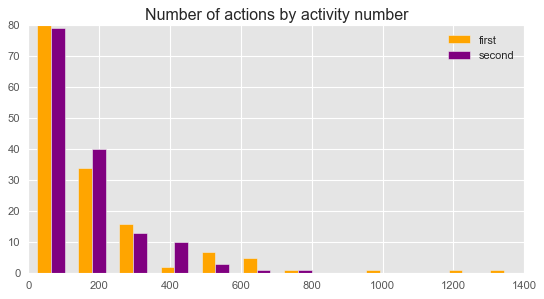

In [19]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['number of actions'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['number of actions'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.legend()
plt.title("Number of actions by activity number")
print

## How long are activities?

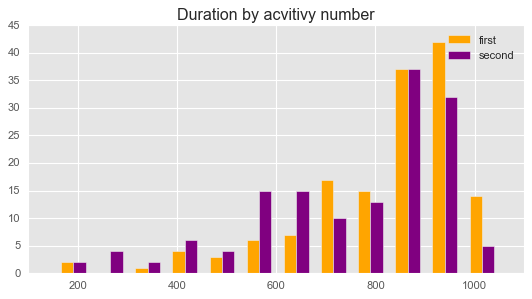

In [20]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['duration'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['duration'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.legend()
plt.title("Duration by acvitivy number")
print

## How long do students explore in each sim?

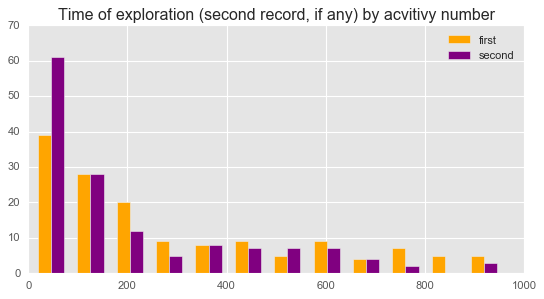

In [21]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['time second record'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['time second record'],bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.legend()
plt.title("Time of exploration (second record, if any) by acvitivy number")
print

So far, we find that most students do less than 200 actions within an activity of over 800s (13.3 min) long and explore for the first 200s (3.3min). In the second activity, it seems like students do more actions in a shorter activity and explore much less.